In [2]:
!pip install qiskit==1.2.0 qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 141.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 131.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [qiskit_machine_learning]_machine_learning]


In [3]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from qiskit_machine_learning.algorithms import QSVR
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [31]:
def load_and_preprocess_data(file_path, date_column, target_column, garbage_columns):
    df = pd.read_excel(file_path)
    df = df.drop(columns=garbage_columns)
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    return df, df.columns.get_loc(target_column)
    # pass

In [32]:
def visualize_data(df, target_column):
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df[target_column], label=target_column)
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.title(f'{target_column} Data')
    plt.legend()
    plt.show()

In [33]:
def split_data(df, train_start, test_start):
    train = df.loc[train_start:test_start]
    test = df.loc[test_start:]
    return train, test

In [34]:
def scale_data(data_train, data_test, train_vars, target_id):
    scaler_feature = MinMaxScaler()
    scaler_target = MinMaxScaler()
    train_scaled = scaler_feature.fit_transform(data_train.iloc[:, train_vars])
    train_target = scaler_target.fit_transform(data_train.iloc[:, target_id].to_frame())
    test_scaled = scaler_feature.transform(data_test.iloc[:, train_vars])
    test_target = scaler_target.transform(data_test.iloc[:, target_id].to_frame())
    return (train_scaled, train_target), (test_scaled, test_target), (scaler_feature, scaler_target)

In [35]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [36]:
def train_qsvr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05, kernel = None):
    model = QSVR(quantum_kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1))
    return model

def train_svr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05):
    model = SVR(gamma=gamma, C=C, epsilon=epsilon)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1))
    return model

In [37]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
    test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

    train_pred_inv = scaler[1].inverse_transform(train_pred.reshape(-1, 1))
    y_train_inv = scaler[1].inverse_transform(y_train.reshape(-1, 1))
    test_pred_inv = scaler[1].inverse_transform(test_pred.reshape(-1, 1))
    y_test_inv = scaler[1].inverse_transform(y_test.reshape(-1, 1))

    mse_train = mean_squared_error(y_train_inv, train_pred_inv)
    mse_test = mean_squared_error(y_test_inv, test_pred_inv)

    print("Mean Squared Error on Training Data:", mse_train)
    print("Mean Squared Error on Testing Data:", mse_test)

    return train_pred_inv, y_train_inv, test_pred_inv, y_test_inv

In [45]:
def plot_results(train, test, train_pred_inv, y_train_inv, test_pred_inv, y_test_inv, time_steps):
    plt.figure(figsize=(15, 8))
    
    # Plot for Training Data
    plt.plot(train.index[:-1], y_train_inv, label='Actual Population (Train)', color='seagreen', linewidth=2)
    plt.plot(train.index[:-1], train_pred_inv, label='Predicted Population (Train)', color='royalblue', linestyle='--', linewidth=2)
    pl
    plt.xlabel('Date', fontsize=20)
    plt.ylabel('Population', fontsize=20)
    
    plt.title('Training Data: Actual vs Predicted Population', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 8))
    
    # Plot for Testing Data
    plt.plot(test.index[:-1], y_test_inv, label='Actual Population (Test)', color='seagreen', linewidth=2)
    plt.plot(test.index[:-1], test_pred_inv, label='Predicted Population (Test)', color='crimson', linestyle='--', linewidth=2)
    
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Population', fontsize=14)
    plt.title('Testing Data: Actual vs Predicted Population', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


#Data prep

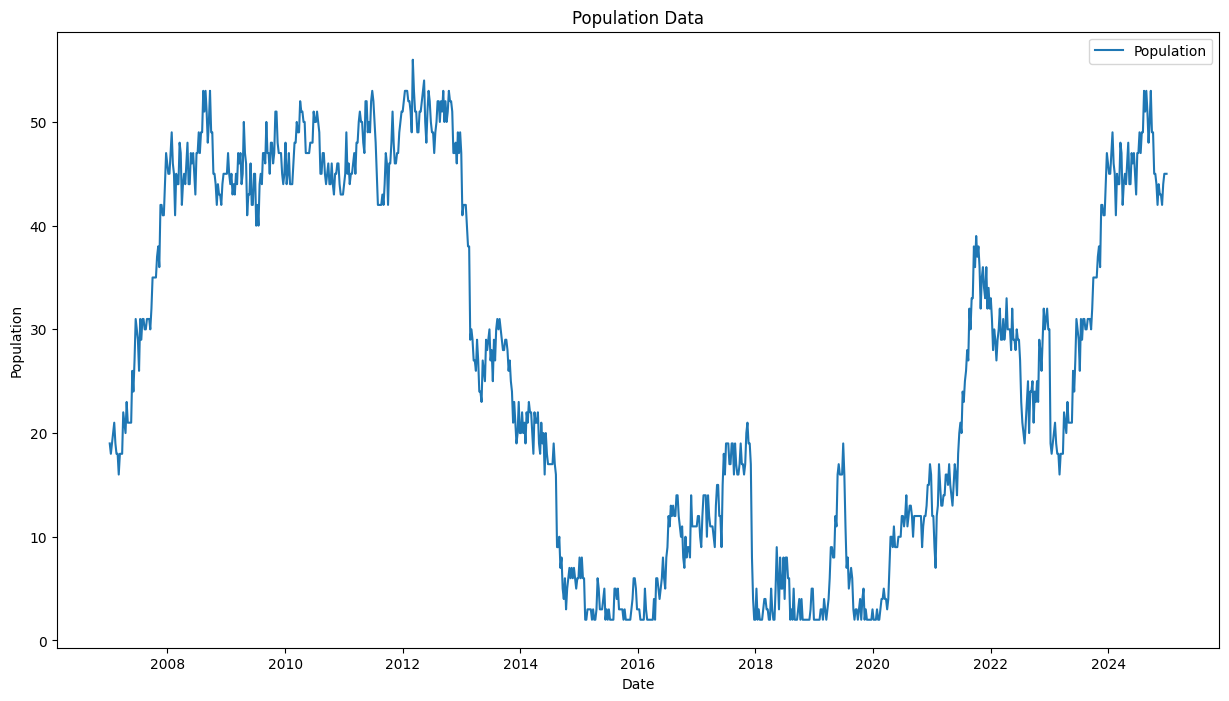

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 939 entries, 2007-01-07 07:52:42 to 2024-12-29 06:14:56
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Population              939 non-null    int64  
 1   10m u wind              939 non-null    float64
 2   10m v wind              939 non-null    float64
 3   2m temp                 939 non-null    float64
 4   avg sea level pressure  939 non-null    float64
 5   surface pressure        939 non-null    float64
 6   total precipitation     939 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 58.7 KB
None
(208, 1, 6) (208, 1) [1, 2, 3, 4, 5, 6]
(51, 1, 6) (51, 1)


In [39]:
# Main execution
file_path = 'ArabianGhezzel_WeeklyTimestamps_2007to2024.xlsx'  # Replace with your dataset path
date_column = 'Timestamp'  # Replace with your date column name
target_column = 'Population'  # Replace with your target column name
garbage_columns = ['Region']
train_start = '2020-01-01'  # Replace with your training start date
test_start = '2024-01-01'  # Replace with your testing start date
time_steps = 1

# Load and preprocess data
df, target_id = load_and_preprocess_data(file_path, date_column, target_column, garbage_columns)
visualize_data(df, target_column)

print(df.info())

# Getting trin variables
train_vars = list(range(df.columns.shape[0]))
train_vars.remove(target_id)

# Split data
train, test = split_data(df, train_start, test_start)

# Scale data
train_scaled, test_scaled, scaler = scale_data(train, test, train_vars, target_id)

# print(target_id, train, train_scaled)


# Prepare data for training
X_train, y_train = create_dataset(train_scaled[0], train_scaled[1], time_steps)
X_test, y_test = create_dataset(test_scaled[0], test_scaled[1], time_steps)

print(X_train.shape, y_train.shape, train_vars)
print(X_test.shape, y_test.shape)

#Train

In [40]:
# kernel
feature_map = ZZFeatureMap(feature_dimension=6*time_steps, reps=1)
qkernel = FidelityQuantumKernel(feature_map=feature_map, enforce_psd=False)

print(feature_map.decompose())


     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_5: ┤ H ├┤ P(2.0*x[5]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«                                     

In [41]:
# Train model
model_q = train_qsvr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05, kernel = qkernel)

In [13]:
model_c = train_svr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05)

#Test

In [42]:
# Evaluate model
def test_fun(model):
    train_pred_inv, y_train_inv, test_pred_inv, y_test_inv = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
    print(test_pred_inv.shape, y_test_inv.shape)
    # Plot results
    plot_results(train, test, train_pred_inv, y_train_inv, test_pred_inv, y_test_inv, time_steps)
    data_to_save = {
        'train': train,
        'test': test,
        'train_pred_inv': train_pred_inv,
        'y_train_inv': y_train_inv,
        'test_pred_inv': test_pred_inv,
        'y_test_inv': y_test_inv,
        'time_steps': time_steps
    }

    # Pickle the dictionary
    with open('results.pkl', 'wb') as f:
        pickle.dump(data_to_save, f) 

    print("✅ Results saved to 'results.pkl'")
    

Mean Squared Error on Training Data: 4.76379560098462
Mean Squared Error on Testing Data: 724.061687944201
(51, 1) (51, 1)


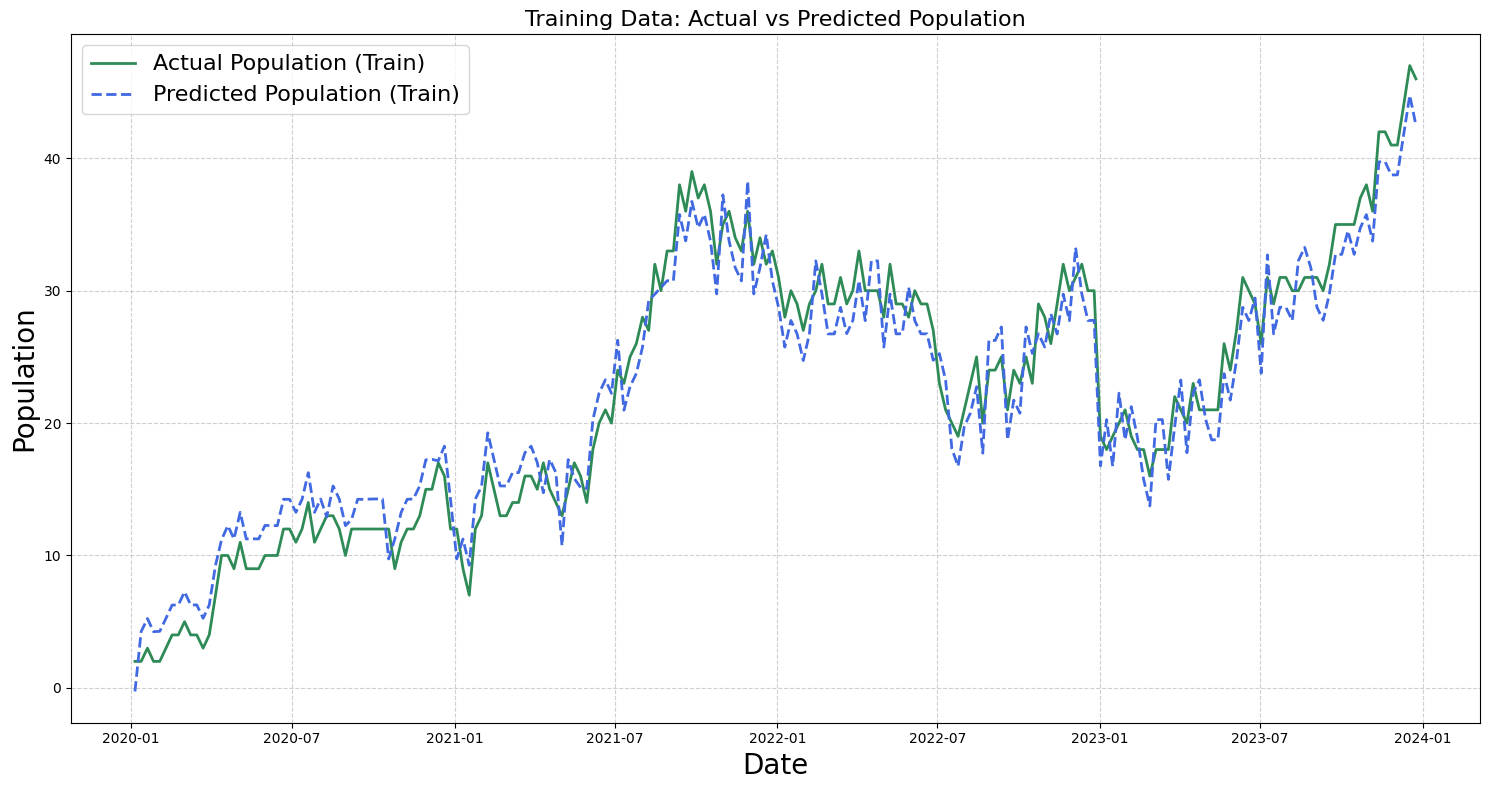

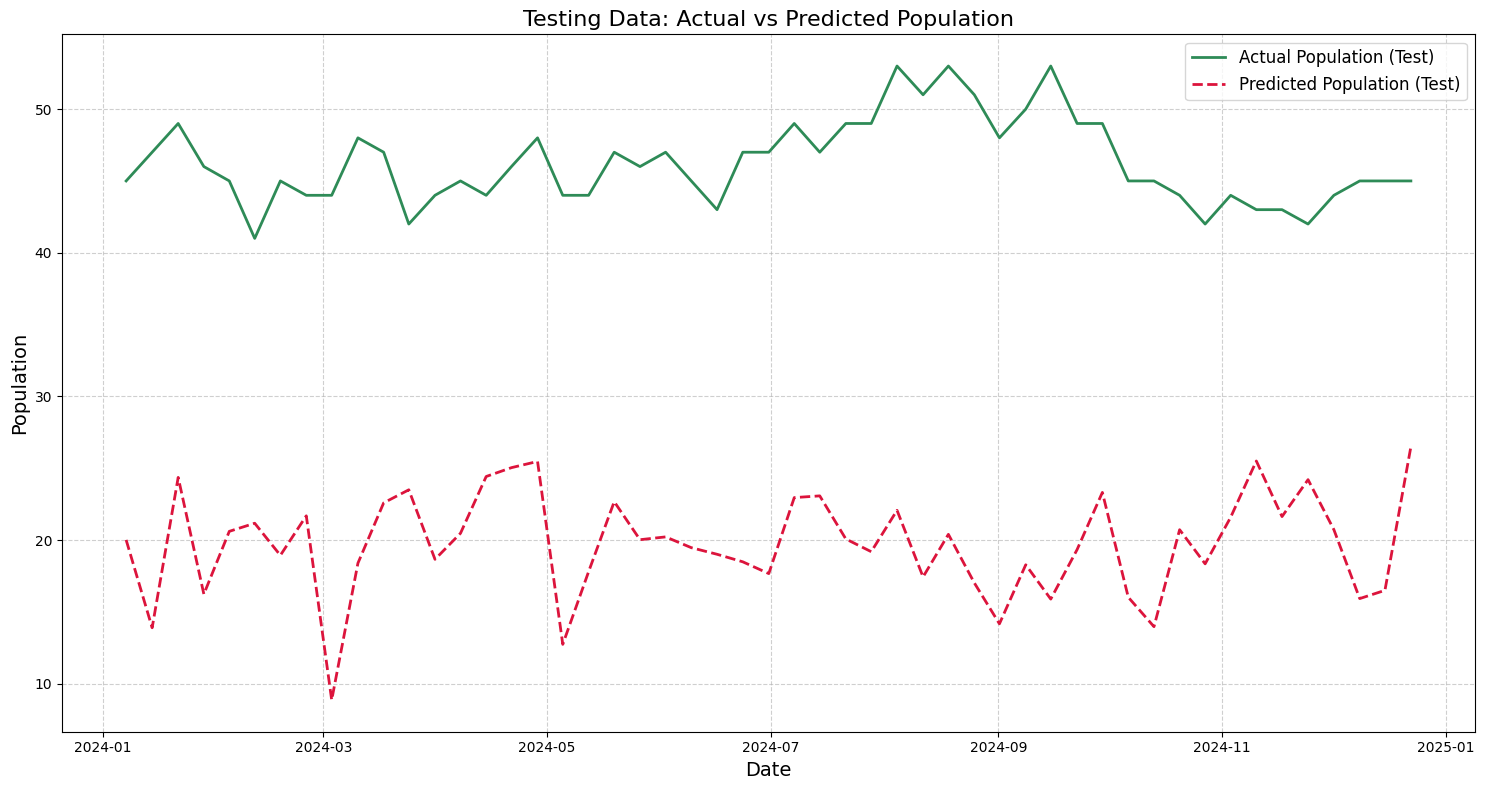

✅ Results saved to 'results.pkl'


In [46]:
test_fun(model_q)

Mean Squared Error on Training Data: 85.19691637103588
Mean Squared Error on Testing Data: 1981.9812579068494
(51, 1) (51, 1)


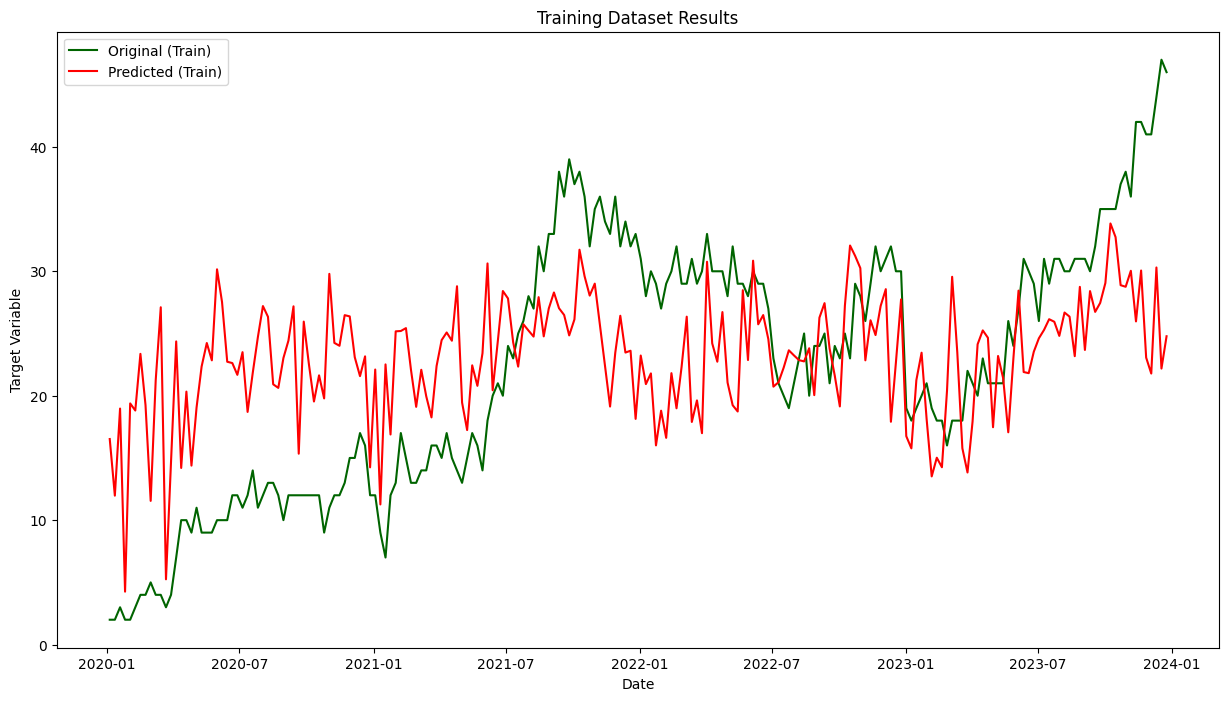

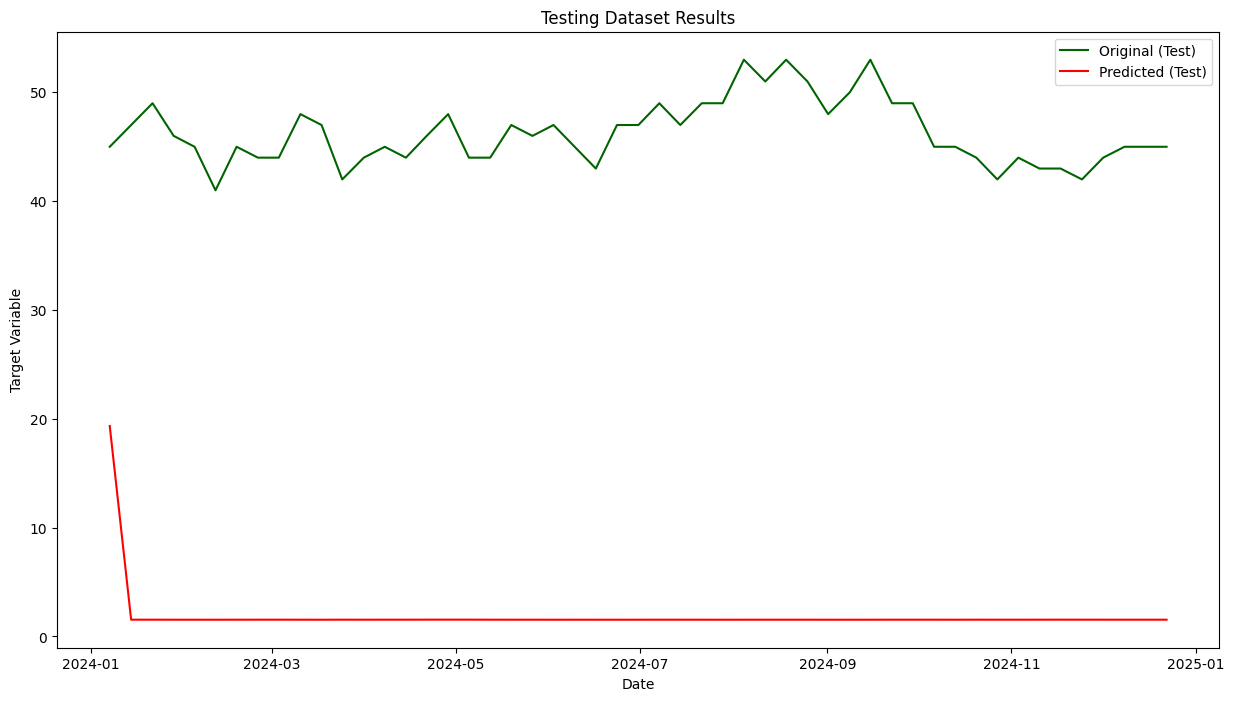

In [16]:
test_fun(model_c)

#Forecast

In [27]:
def forecast(model):
    # Number of future time steps to forecast
    future_steps = 52  # Adjust this as needed

    # Last `TIME_STEPS` values from the test set to start forecasting
    last_sequence = X_test[-1]

    # Forecast future values
    future_forecast = []
    for _ in range(future_steps):
        # Predict next value based on the last sequence
        next_pred = model.predict(last_sequence.reshape(1, -1))
        future_forecast.append(next_pred[0])
        # Update the last sequence by removing the first element and adding the predicted value
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_pred

    # Inverse scaling for future forecast
    future_forecast_inv = scaler[1].inverse_transform(np.array(future_forecast).reshape(-1, 1))

    # Filter out negative values
    future_forecast_inv = np.where(future_forecast_inv < 0, np.nan, future_forecast_inv)

    # Generate future timestamps
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='W')[1:]

    # Plotting the future forecast
    plt.figure(figsize=(15, 8))
    
    # Color zones
    plt.axhspan(0, 10, facecolor='lightcoral', alpha=0.3, label='Near Extinction (0-10)')
    plt.axhspan(10, 20, facecolor='gold', alpha=0.3, label='Endangered (10-20)')
    plt.axhspan(20, 30, facecolor='lightskyblue', alpha=0.3, label='Vulnerable (20-30)')
    plt.axhspan(30, 40, facecolor='lightgreen', alpha=0.3, label='Stable (30-40)')
    plt.axhspan(40, plt.ylim()[1], facecolor='darkgreen', alpha=0.3, label='Healthy (40+)')

    # Plot historical and forecast data
    plt.plot(df.index, df['Population'], label='Historical Data', color='darkgreen')
    plt.plot(future_dates, future_forecast_inv, label='Future Forecast', color='blue')

    # Add horizontal zone lines
    for y in [0, 10, 20, 30, 40]:
        plt.axhline(y=y, color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Date')
    plt.ylabel('Population')
    plt.title('Population Future Forecast with SVR')
    plt.legend()
    plt.show()


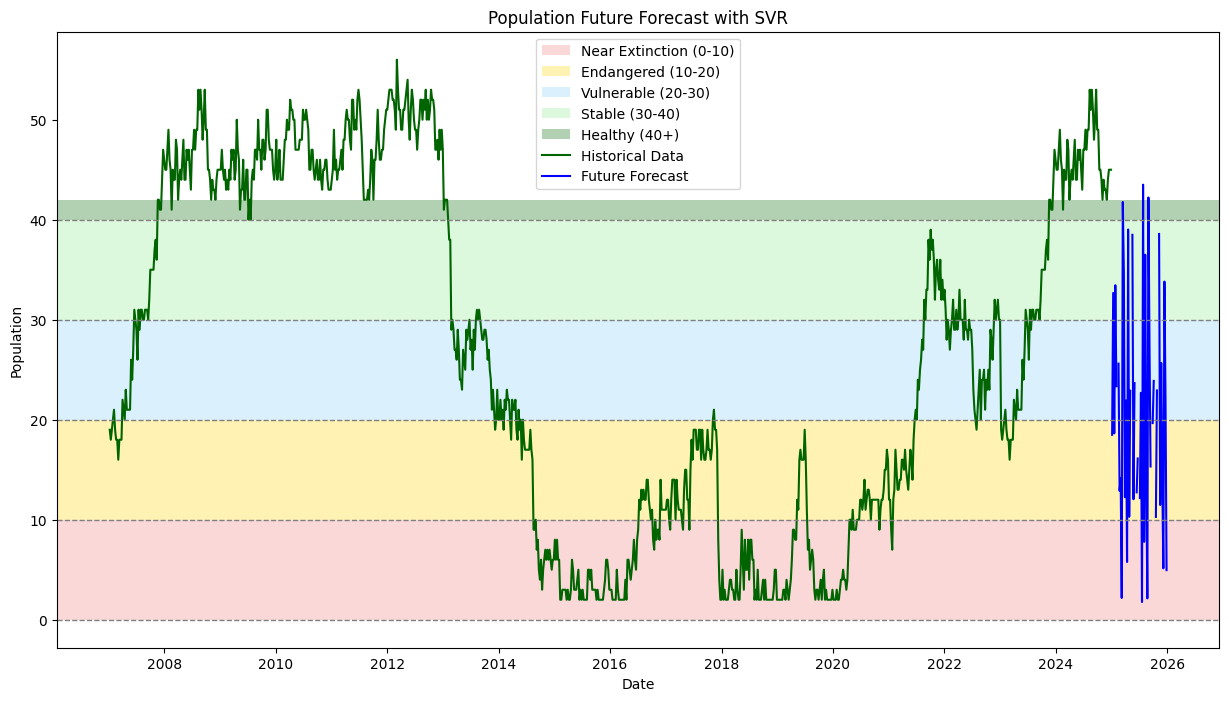

In [28]:
forecast(model_q)

In [ ]:
forecast(model_c)